In [33]:
import json
from distance import Edit_suggester
from preprocessing import preprocess
import random
import matplotlib.pyplot as plt

Creating the dictionary and the edit suggester

In [2]:
with open('data/articles_cleaned_vocabulary.json', 'r', encoding="utf-8") as f:
    vocabulary = [d[0] for d in json.load(f)]

with open('data/bgjargon_words.json', 'r', encoding="utf-8") as f:
    bgjargon_dict = [word for word in json.load(f) if len(word.split(' ')) == 1]

edit_suggester = Edit_suggester(2, vocabulary + bgjargon_dict)

In [3]:
edit_suggester.ngram_all_closest_words('пътка', 0.25, 0)

['пъпка',
 'пъшка',
 'патка',
 'пътека',
 'пътна',
 'пъска',
 'питка',
 'петка',
 'путка']

Reading the bad words

In [4]:
with open('data/bgjargon_bad_tags_ld.json', 'r', encoding="utf-8") as f:
    bad_words = set(json.load(f).keys())

Loading the comments

In [5]:
with open('data/blitz_comments_v2.json', 'r', encoding="utf-8") as f:
    comments = json.load(f)

Loading the manually classified comments

In [6]:
with open('data/blitz_comments_classified.json', 'r', encoding="utf-8") as f:
    gold_comments = [comment_record for comment_record in json.load(f) if len(comment_record) > 2]

## Classifying as profane if the first suggestion is profane

In [49]:
def precision_and_recall_of_word_similarity_annotation_with_best_suggestion(profanity_probability_threshold, edit_tolerance) -> (float, float):
    def auto_classification_as_p(comment: dict[str, str]) -> bool:
        tokens = preprocess(comment[0])
        for token in tokens:
            spellcheck = edit_suggester.ngram_spellcheck(token, jaccard_threshold=0.3)
            if spellcheck != 'None' and spellcheck in bad_words:
                return True
        return False

    tp, fn, fp = 0, 0, 0
    for comment in random.choices(gold_comments, k=100):
        if auto_classification_as_p(comment):
            if comment[2] == 'p':
                tp += 1
            else:
                fp += 1
        else:
            if comment[2] == 'p':
                fn += 1
    return tp/(tp + fp), tp/(tp + fn)

In [51]:
precision, recall = precision_and_recall_of_word_similarity_annotation_with_best_suggestion(p_t, t)
f1 = 2*precision*recall/(precision + recall)
result = (precision, recall, f1)
print(result)

(0.625, 0.7142857142857143, 0.6666666666666666)


## Classifying as profane if one of the best suggestions is profane

In [52]:
def precision_and_recall_of_word_similarity_annotation_with_multiple_suggestions(edit_tolerance) -> (float, float):
    def auto_classification_as_p(comment: dict[str, str]) -> bool:
        tokens = preprocess(comment[0])
        for token in tokens:
            suggestions = edit_suggester.ngram_all_closest_words(token, 0.3, edit_tolerance)
            for suggestion in suggestions:
                if suggestion in bad_words:
                    return True
        return False

    tp, fn, fp = 0, 0, 0
    for comment in random.choices(gold_comments, k=100):
        if auto_classification_as_p(comment):
            if comment[2] == 'p':
                tp += 1
            else:
                fp += 1
        else:
            if comment[2] == 'p':
                fn += 1
    return tp/(tp + fp), tp/(tp + fn)

In [53]:
edit_tolerance = [0, 1, 2, 3]
results = []
for t in edit_tolerance:
    precision, recall = precision_and_recall_of_word_similarity_annotation_with_multiple_suggestions(t)
    f1 = 2*precision*recall/(precision + recall)
    result = (precision, recall, f1)
    print(f"tolerance={t} -> {result}")
    results.append(result)

tolerance=0 -> (0.2876712328767123, 0.7777777777777778, 0.42)
tolerance=1 -> (0.26881720430107525, 0.9259259259259259, 0.4166666666666667)
tolerance=2 -> (0.25773195876288657, 1.0, 0.40983606557377045)
tolerance=3 -> (0.32323232323232326, 0.9696969696969697, 0.48484848484848486)


## Probabilistic

We define the probability of one word to be classified as profane as the number of bad words in the suggestions/number of suggestions

In [21]:
def profanity_probability(token, edit_tolerance) -> float:
    bad_words_in_suggestions = 0
    suggestions = edit_suggester.ngram_all_closest_words(token, 0.3, edit_tolerance)
    if len(suggestions) == 0:
        return 0
    for suggestion in suggestions:
        if suggestion in bad_words:
            bad_words_in_suggestions += 1

    return bad_words_in_suggestions/len(suggestions)

Experimenting with different parameters for auto annotation

In [28]:
def precision_and_recall_of_word_similarity_annotation(profanity_probability_threshold, edit_tolerance) -> (float, float):
    def auto_classification_as_p(comment: dict[str, str]) -> bool:
        tokens = preprocess(comment[0])
        for token in tokens:
            if profanity_probability(token, edit_tolerance) >= profanity_probability_threshold:
                return True
        return False

    tp, fn, fp = 0, 0, 0
    for comment in random.choices(gold_comments, k=100):
        if auto_classification_as_p(comment):
            if comment[2] == 'p':
                tp += 1
            else:
                fp += 1
        else:
            if comment[2] == 'p':
                fn += 1
    return tp/(tp + fp), tp/(tp + fn)

In [29]:
profanity_probability_threshold = [1, 0.5, 0.33, 0.25, 0.20, 0.15, 0.10, 0.05, 0.02, 0.01]
edit_tolerance = [0, 1, 2, 3]
results = []
for p_t in profanity_probability_threshold:
    for t in edit_tolerance:
        precision, recall = precision_and_recall_of_word_similarity_annotation(p_t, t)
        f1 = 2*precision*recall/(precision + recall)
        result = (precision, recall, f1)
        print(f"probability_thresholds={p_t} and tolerance={t} -> {result}")
        results.append(result)

probability_thresholds=1 and tolerance=0 -> (0.4634146341463415, 0.76, 0.5757575757575758)
probability_thresholds=1 and tolerance=1 -> (0.5087719298245614, 0.90625, 0.651685393258427)
probability_thresholds=1 and tolerance=2 -> (0.5833333333333334, 0.56, 0.5714285714285714)
probability_thresholds=1 and tolerance=3 -> (0.5652173913043478, 0.3611111111111111, 0.44067796610169496)
probability_thresholds=0.5 and tolerance=0 -> (0.35384615384615387, 0.8214285714285714, 0.4946236559139785)
probability_thresholds=0.5 and tolerance=1 -> (0.22857142857142856, 0.6666666666666666, 0.3404255319148936)
probability_thresholds=0.5 and tolerance=2 -> (0.43478260869565216, 0.6896551724137931, 0.5333333333333333)
probability_thresholds=0.5 and tolerance=3 -> (0.5172413793103449, 0.45454545454545453, 0.4838709677419355)
probability_thresholds=0.33 and tolerance=0 -> (0.3561643835616438, 0.7878787878787878, 0.49056603773584906)
probability_thresholds=0.33 and tolerance=1 -> (0.25316455696202533, 0.8695652

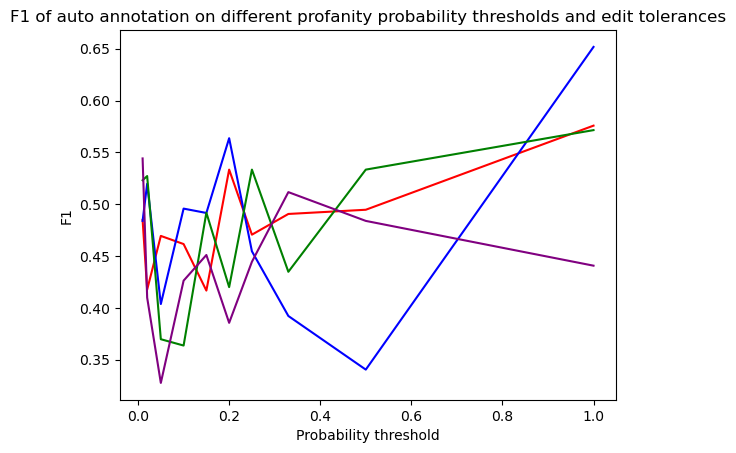

In [38]:
f1s_tol_0, f1s_tol_1, f1s_tol_2, f1s_tol_3 = [], [], [], []
for i in range(len(results)):
    if i%4 == 0:
        f1s_tol_0.append(results[i][2])
    if i%4 == 1:
        f1s_tol_1.append(results[i][2])
    if i%4 == 2:
        f1s_tol_2.append(results[i][2])
    if i%4 == 3:
        f1s_tol_3.append(results[i][2])

plt.title("F1 of auto annotation on different profanity probability thresholds and edit tolerances")
plt.xlabel("Probability threshold")
plt.ylabel("F1")
plt.plot(profanity_probability_threshold, f1s_tol_0, label = "tolerance = 0", color = 'red')
plt.plot(profanity_probability_threshold, f1s_tol_1, label = "tolerance = 1", color = 'blue')
plt.plot(profanity_probability_threshold, f1s_tol_2, label = "tolerance = 2", color = 'green')
plt.plot(profanity_probability_threshold, f1s_tol_3, label = "tolerance = 3", color = 'purple')
plt.show()

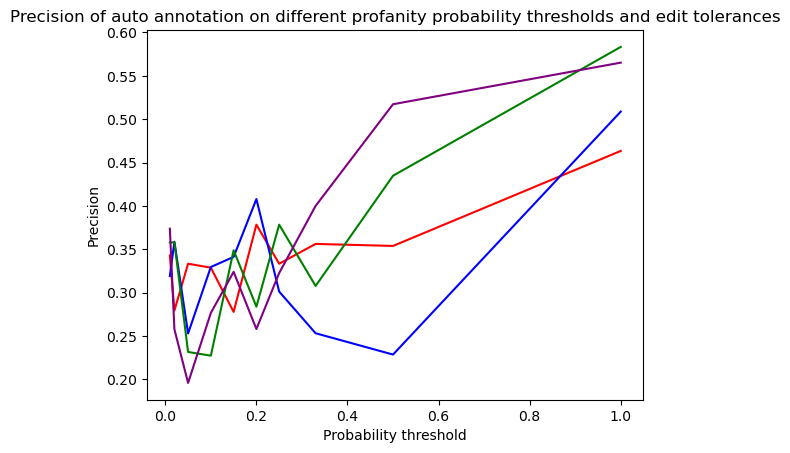

In [42]:
p_tol_0, p_tol_1, p_tol_2, p_tol_3 = [], [], [], []
for i in range(len(results)):
    if i%4 == 0:
        p_tol_0.append(results[i][0])
    if i%4 == 1:
        p_tol_1.append(results[i][0])
    if i%4 == 2:
        p_tol_2.append(results[i][0])
    if i%4 == 3:
        p_tol_3.append(results[i][0])

plt.title("Precision of auto annotation on different profanity probability thresholds and edit tolerances")
plt.xlabel("Probability threshold")
plt.ylabel("Precision")
plt.plot(profanity_probability_threshold, p_tol_0, label = "tolerance = 0", color = 'red')
plt.plot(profanity_probability_threshold, p_tol_1, label = "tolerance = 1", color = 'blue')
plt.plot(profanity_probability_threshold, p_tol_2, label = "tolerance = 2", color = 'green')
plt.plot(profanity_probability_threshold, p_tol_3, label = "tolerance = 3", color = 'purple')
plt.show()

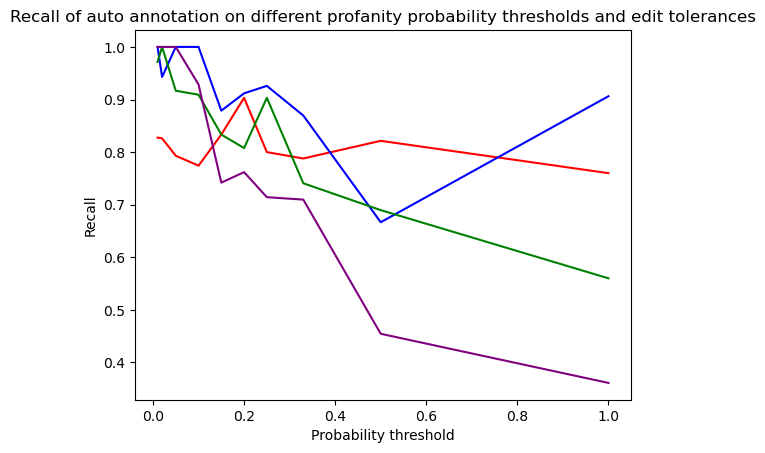

In [44]:
r_tol_0, r_tol_1, r_tol_2, r_tol_3 = [], [], [], []
for i in range(len(results)):
    if i%4 == 0:
        r_tol_0.append(results[i][1])
    if i%4 == 1:
        r_tol_1.append(results[i][1])
    if i%4 == 2:
        r_tol_2.append(results[i][1])
    if i%4 == 3:
        r_tol_3.append(results[i][1])

plt.title("Recall of auto annotation on different profanity probability thresholds and edit tolerances")
plt.xlabel("Probability threshold")
plt.ylabel("Recall")
plt.plot(profanity_probability_threshold, r_tol_0, label = "tolerance = 0", color = 'red')
plt.plot(profanity_probability_threshold, r_tol_1, label = "tolerance = 1", color = 'blue')
plt.plot(profanity_probability_threshold, r_tol_2, label = "tolerance = 2", color = 'green')
plt.plot(profanity_probability_threshold, r_tol_3, label = "tolerance = 3", color = 'purple')
plt.show()

# Conclusion
Still the classifying with the single best suggestion gives the best results

Auto annotation

In [ ]:
from preprocessing import preprocess

def has_profanity(comment: dict[str, str]) -> bool:
    tokens = preprocess(comment['comment'])
    for token in tokens:
        spellcheck = edit_suggester.ngram_spellcheck(token, jaccard_threshold=0.3)
        if spellcheck != 'None' and spellcheck in bad_words:
            return True
    return False

auto_annotated_comments = []
for comment in comments:
    if has_profanity(comment):
        auto_annotated_comments.append({
            'comment': comment['comment'],
            'author': comment['author'],
            'class': 'p'
            })
    else:
        auto_annotated_comments.append({
            'comment': comment['comment'],
            'author': comment['author'],
            'class': 'n'
            })

In [9]:
import codecs

json_object = json.dumps(auto_annotated_comments, indent=4, ensure_ascii=False)
with codecs.open("data/blitz_comments_auto_classified.json", "w", "utf-8") as outfile:
    outfile.write(json_object)